In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']= 'TRUE'
import numpy as np
# np.save('Nv.npy', Nv)
Nv = np.load('Nv.npy')
print(Nv)
Sv = np.load('Sv.npy')
print(Sv)
from scipy import interpolate
param = (interpolate.InterpolatedUnivariateSpline(Nv, Sv),)    

[0.000e+00 1.000e-02 2.000e-02 ... 6.738e+01 6.739e+01 6.740e+01]
[1.         1.         1.         ... 0.32904425 0.32245421 0.31593402]


In [3]:
from bson import ObjectId
import pymongo
from tqdm import tqdm
client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client["solve"]
collection = db["ivp"]


for document in tqdm(collection.find().limit(1)): 
    N_span = document['N_span']
    ini_state = document['ini_state']

from scipy import interpolate
param = (interpolate.InterpolatedUnivariateSpline(Nv, Sv),)    
# import numpy as np
# # np.save('Nv.npy', Nv)
# loaded_arr = np.load('Nv.npy')
# print(loaded_arr)

1it [00:00, 166.41it/s]


In [4]:
import math
import numpy as np
from scipy.integrate import quad
from scipy.integrate import solve_ivp
def tensor(N, state, spline):
    """
    Dynamical system for tensor modes:
    
    z = ln(2*pi*f/aH)
    x = \dot T_h / H
    y = (2*pi*f/aH) * T_h
    sigma = -2 \dot H / 3H^2

    z' = 1.5*sigma - 1                
    x' = -3*x + 1.5*sigma*x - exp(z)*y
    y' = -y + 1.5*sigma*y + exp(z)*x 
    
    """
    
    z, x, y = state
    sigma = float(spline(N))
    
    dz = 1.5*sigma - 1
    dx = -3*x + 1.5*sigma*x - math.exp(z)*y
    dy = -y + 1.5*sigma*y + math.exp(z)*x 
    
    return [dz, dx, dy]

def subhorizon(N, state, spline):         # Deep-inside-the-Hubble threshold: k/aH = exp(5) ～ 150
    return state[0]-5

subhorizon.terminal = True; subhorizon.direction = 1

def jacobian(N, state, spline):
    
    z, x, y = state
    sigma = float(spline(N))
    
    jac = np.array(
        (
            (0, 0, 0),
            (-math.exp(z)*y, -3+1.5*sigma, -math.exp(z)),
            (math.exp(z)*x, math.exp(z), -1+1.5*sigma),
        ),
        dtype = np.float64,
    )
    
    return jac

In [5]:
result = solve_ivp(tensor, N_span, ini_state, 
                       method='LSODA', 
                       #t_eval=N,
                       dense_output=True,
                       events=[subhorizon,],
                       args=param,
                       rtol=1e-6, atol=[1e-10, 1e-20, 1e-20],
                       jac=jacobian,
                      )

In [21]:
import timeit
from tqdm import tqdm
solve_time = []
# 计算 solve_ivp 的执行时间
for i in tqdm(range(1000)):
    solve_ivp_time = timeit.timeit('''solve_ivp(tensor, N_span, ini_state, 
                           method='LSODA', 
                           #t_eval=N,
                           dense_output=True,
                           events=[subhorizon,],
                           args=param,
                           rtol=1e-6, atol=[1e-10, 1e-20, 1e-20],
                           jac=jacobian,
                          )''', 
                                   globals=globals(), number=1)
    solve_time.append(solve_ivp_time)
# print(f"solve_ivp 执行时间（1000次）：{solve_ivp_time:.6f} 秒")

# 同样可以对深度学习模型进行测试
# model_time = timeit.timeit('model(input_data)', globals=globals(), number=100)
# print(f"深度学习模型执行时间（100次）：{model_time:.6f} 秒")


100%|██████████| 1000/1000 [01:09<00:00, 14.30it/s]


In [26]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
import torch
from scipy.integrate import solve_ivp
import math
import torch.nn as nn

class ODE_Network(nn.Module):
    def __init__(self):
        super(ODE_Network, self).__init__()
        self.fc1 = nn.Linear(6, 128)
        self.fc21 = nn.Linear(128, 256)
        self.fc2 = nn.Linear(128, 64)
        self.fc22 = nn.Linear(256, 512)
        self.fc23 = nn.Linear(512, 128)
        self.fc24 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 3)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc21(x))
        x = torch.relu(self.fc22(x))
        x = torch.relu(self.fc23(x))
        x = torch.relu(self.fc24(x))
        x = self.fc3(x)
        return x

model = ODE_Network()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

import time

model.load_state_dict(torch.load('ode_model_fc22.pth'))
model.eval()
import matplotlib as mpl
mpl.rcParams['font.weight'] = 'bold' 


for document in tqdm(collection.find().limit(1)): 
    N_effective = Nv[(Nv >= result.sol.t_min) & (Nv <= result.sol.t_max)]
    t1=time.time()
    for t in N_effective:
        new_train_inputs = []
        new_train_inputs.append([t] + [N_span[0], N_span[1]] + list(document['ini_state']))
        
model_time = []
# 计算 solve_ivp 的执行时间
for i in tqdm(range(1000)):
# 计算 solve_ivp 的执行时间
    solve_model_time = timeit.timeit('''predictions = model(torch.tensor(new_train_inputs, dtype=torch.float32))''', 
                                   globals=globals(), number=1)
    model_time.append(solve_model_time)

# print(f"solve_ivp 执行时间（1000次）：{solve_ivp_time:.6f} 秒")

C:\Users\matie\AppData\Local\Temp\ipykernel_15164\672145980.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('ode_model_fc22.pth'))
1it 

In [ ]:
Nv = np.array(Nv)
N_this = Nv[(Nv >= result.sol.t_min) & (Nv <= result.sol.t_max)]
[zf_this, xf_this, yf_this] = result.sol(N_this)
result

  message: A termination event occurred.
  success: True
   status: 1
        t: [ 1.210e+01  1.210e+01 ...  3.592e+01  3.592e+01]
        y: [[-6.912e+00 -6.912e+00 ...  5.000e+00  5.000e+00]
            [ 0.000e+00 -1.000e-17 ...  5.003e-03  5.047e-03]
            [ 9.954e-04  9.954e-04 ... -7.429e-04 -2.559e-04]]
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x00000215B16629B0>
 t_events: [array([ 3.592e+01])]
 y_events: [array([[ 5.000e+00,  5.047e-03, -2.559e-04]])]
     nfev: 5299
     njev: 420
      nlu: 420

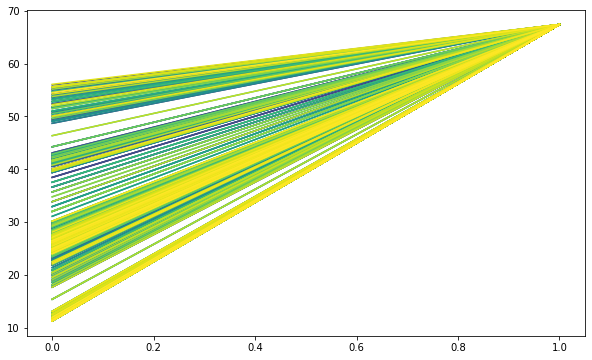

In [11]:
import matplotlib.pyplot as plt
random_columns=df.sample(n=1000, axis=0)
plt.figure(figsize=(10, 6))
colors=plt.cm.viridis(np.linspace(0, 1, 1000))
for i, (index, array) in enumerate(random_columns.iterrows()):
    plt.plot(array['N_span'], color=colors[i], label=f'Line {i+1}')
# for array in random_columns['param_Sv']:
#     plt.plot(array, color='blue', alpha=0.3)


In [10]:
df['N_span']

0        [12.1, 67.4]
1       [12.22, 67.4]
2       [23.69, 67.4]
3       [24.85, 67.4]
4       [27.48, 67.4]
            ...      
9995    [24.62, 67.4]
9996    [11.32, 67.4]
9997    [11.28, 67.4]
9998    [27.48, 67.4]
9999    [12.66, 67.4]
Name: N_span, Length: 10000, dtype: object

[0.000e+00 1.000e-02 2.000e-02 ... 6.738e+01 6.739e+01 6.740e+01]


[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [29]:
model_time

[0.000492600000143284,
 0.00020819999917875975,
 0.00018430000272928737,
 0.00019360000078449957,
 0.00019210000027669594,
 0.00024340000163647346,
 0.00021580000247922726,
 0.00024929999926825985,
 0.0002310999989276752,
 0.00017099999968195334,
 0.00017410000145900995,
 0.0002445999998599291,
 0.0002973000009660609,
 0.00024299999859067611,
 0.0002423999976599589,
 0.00022710000121151097,
 0.0003171999996993691,
 0.00025860000096145086,
 0.00019149999934597872,
 0.00018619999900693074,
 0.00017659999866737053,
 0.0001747999995131977,
 0.00018389999968349002,
 0.00018740000086836517,
 0.0001905999997688923,
 0.00018379999892204069,
 0.0001843999998527579,
 0.0001947999990079552,
 0.00019149999934597872,
 0.0002091999995172955,
 0.00020009999934700318,
 0.00020699999731732532,
 0.00020560000120894983,
 0.000248799999098992,
 0.00021270000070217066,
 0.00021710000146413222,
 0.0002057999990938697,
 0.0001998999978241045,
 0.00020419999782461673,
 0.00020559999757097103,
 0.0001914999993

In [27]:
solve_time

[0.06752260000212118,
 0.061557799999718554,
 0.06281119999766815,
 0.06050959999993211,
 0.061901599998236634,
 0.06430710000131512,
 0.06615220000094268,
 0.06276519999664742,
 0.06273580000197398,
 0.0623529000004055,
 0.06574919999911799,
 0.06729260000065551,
 0.07166270000016084,
 0.06980010000188486,
 0.0731828999996651,
 0.06159499999921536,
 0.06638139999995474,
 0.06956740000168793,
 0.07056120000197552,
 0.06506470000022091,
 0.06831959999908577,
 0.06984060000104364,
 0.0631377000026987,
 0.06683710000288556,
 0.07185540000136825,
 0.06749649999983376,
 0.06876879999981611,
 0.0672045999999682,
 0.06964719999814406,
 0.06711320000249543,
 0.06896180000330787,
 0.06601520000185701,
 0.07301860000006855,
 0.06751620000068215,
 0.0659081999983755,
 0.06620639999891864,
 0.07228380000015022,
 0.06737639999846579,
 0.07385459999932209,
 0.06682130000262987,
 0.06780179999987013,
 0.06771970000045258,
 0.07568859999810229,
 0.06975410000086413,
 0.07059649999791873,
 0.0607610999

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


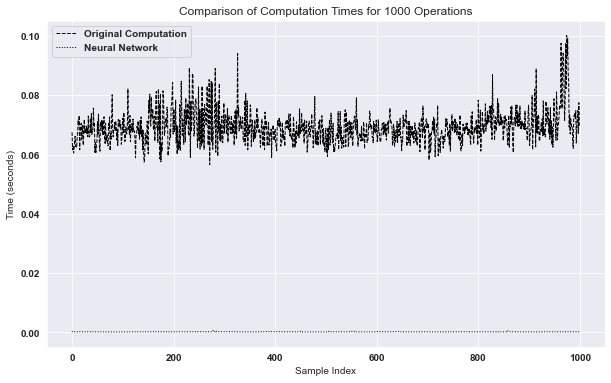

In [35]:
import matplotlib.pyplot as plt
import numpy as np


# 绘制折线图
plt.figure(figsize=(10, 6))
plt.plot(solve_time, label='Original Computation', color='black', linestyle='--', linewidth=1)
plt.plot(model_time, label='Neural Network', color='black', linestyle=':', linewidth=1)

# 添加标题和标签
plt.title('Comparison of Computation Times for 1000 Operations')
plt.xlabel('Sample Index')
plt.ylabel('Time (seconds)')

# 添加图例
plt.legend()
plt.savefig("solve_time_comparison.eps", dpi=1200)
# 显示图表
plt.show()
